In [1016]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1017]:
import pandas as pd
import itertools
from collections import namedtuple
from plotnine import *
from multiprocessing import Pool
from IPython.core import display as ICD
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, classification_report, log_loss, accuracy_score

In [1018]:
animals = pd.read_csv('animal')
animals = animals.rename(columns = {'Unnamed: 0':'ID',
                                    'type':'Type', 
                                    'SizeScore(1to5)': 'SizeScore', 
                                    'AvgWeight(pounds)': 'AvgWeight'})
animals.drop(['Year'], inplace=True, axis=1) # we have two years were we only have a small amount of data
pd.set_option('display.max_columns', None)
animals = animals.iloc[:, [0, 4, 11, 12] + range(14, animals.columns.size)]
cats = animals[animals.Type==1].copy()
dogs = animals[animals.Type==0].copy()
dogs.Hair = 'Medium'
cats.AvgAge = 12

In [1019]:
imputer = Imputer(strategy='median')   
dogs.fillna(dogs.median(), axis=0, inplace=True)
cats.fillna(cats.median(), axis=0, inplace=True)
animals = pd.concat([dogs, cats])
ICD.display(animals.head())
ICD.display(animals.tail())

,ID,OutcomeType,Type,HasName,Month,Weekday,Hour,WeekofYear,DayofMonth,isHoliday,AgeinDays,LifeStage,BernoulliSex,AvgWeight,SizeScore,AvgAge,Intelligent,Friendliness,MixType,Hair,ReducedColor,ReducedPattern
0,0,Return_to_owner,0,1.0,2,2,18,7,12,False,365.0,Puppy/Kitten,Neutered Male,28.0,2.0,13.0,5.0,4.0,Mix,Medium,Brown/White,BiColor
2,2,Adoption,0,1.0,1,5,12,5,31,True,730.0,Young Adult,Neutered Male,60.0,4.0,12.0,4.0,2.0,Mix,Medium,Grey/White,BiColor
4,4,Transfer,0,0.0,11,4,12,46,15,False,730.0,Young Adult,Neutered Male,14.0,2.0,15.0,4.0,4.0,Cross,Medium,Tan,Solid
5,5,Transfer,0,1.0,4,4,13,17,25,False,31.0,Infant,Intact Female,10.0,1.0,16.0,4.0,3.0,Cross,Medium,Black/Tan,BiColor
8,8,Adoption,0,1.0,2,1,17,6,4,False,155.0,Infant,Spayed Female,60.0,4.0,12.0,4.0,2.0,Mix,Medium,Red/White,BiColor


,ID,OutcomeType,Type,HasName,Month,Weekday,Hour,WeekofYear,DayofMonth,isHoliday,AgeinDays,LifeStage,BernoulliSex,AvgWeight,SizeScore,AvgAge,Intelligent,Friendliness,MixType,Hair,ReducedColor,ReducedPattern
26722,26722,Transfer,1,0.0,8,6,9,35,31,True,155.0,Infant,Intact Male,9.0,1.0,12.0,3.0,3.0,Mix,Short,Orange,Tabby
26724,26724,Transfer,1,0.0,5,3,11,20,14,False,31.0,Infant,Intact Male,9.0,1.0,12.0,3.0,3.0,Mix,Short,Brown/White,Tabby
26725,26725,Transfer,1,0.0,1,2,18,3,20,True,93.0,Infant,Spayed Female,9.0,1.0,12.0,3.0,3.0,Mix,Short,Brown,Tabby
26727,26727,Transfer,1,0.0,4,6,12,17,27,True,28.0,Infant,Intact Male,9.0,1.0,12.0,3.0,3.0,Mix,Short,Black,Solid
26728,26728,Transfer,1,0.0,7,3,9,27,2,True,365.0,Puppy/Kitten,Intact Male,9.0,1.0,12.0,3.0,3.0,Mix,Short,Brown/White,Tabby


In [1020]:
continuous = [
    'AgeinDays', 
    'AvgWeight', 
    'AvgAge'
]

# Ensure order is correct if treated as continuous (value of dictonary). Doing 1-hot doesn't seem to work as
# well with RF. But order matters a lot here (i.e. LifeStage won't work properly if not set as below -- the 
# order it automatically creates is not in the order of the stages). Commenting out the features that don't 
# work after trail and error (on RF).
discrete = dict(
    # Type = None,
    HasName = None,
    Month = range(12),
    Weekday = range(7),
    Hour = [0] + range(5, 24),
    WeekofYear = range(53),
    DayofMonth = range(31), # why does this one matter, seems it shouldn't -- need to try without
    # isHoliday = None,
    # LifeStage = ["Unknown", "Infant", "Puppy/Kitten", "Young Adult", "Adult", "Senior", "Geriatric"],
    BernoulliSex = ['Intact Male', 'Intact Female', 'Neutered Male', 'Spayed Female'],
    # SizeScore = range(1, 6),
    # Intelligent = range(2, 6),
    # Friendliness = range(1, 6),
    # MixType = ['Cross', 'Mix', 'Pure'],
    # Hair = ['Long', 'Medium', 'Short'],
    # ReducedColor = None,
    # ReducedPattern = ['Solid', 'BiColor', 'TriColor', 'Tabby', 'Mertle', 'Point', 'Smoke']
)

encode_discrete_as_one_hot = False

df = animals.iloc[:, 1:2].copy()
for c in animals.iloc[:, 2:].columns:
    if c in continuous:
        df[c] = animals[c]
    elif c in discrete.keys():
        if encode_discrete_as_one_hot:
            df = pd.concat([df, pd.get_dummies(pd.Categorical(animals[c]), prefix=c)], axis=1)
        else:
            df[c] = pd.Categorical(animals[c], categories=discrete[c]).codes         
            
df.head()
    

,OutcomeType,HasName,Month,Weekday,Hour,WeekofYear,DayofMonth,AgeinDays,BernoulliSex,AvgWeight,AvgAge
0,Return_to_owner,1,2,2,14,7,12,365.0,2,28.0,13.0
2,Adoption,1,1,5,8,5,-1,730.0,2,60.0,12.0
4,Transfer,0,11,4,8,46,15,730.0,2,14.0,15.0
5,Transfer,1,4,4,9,17,25,31.0,1,10.0,16.0
8,Adoption,1,2,1,13,6,4,155.0,3,60.0,12.0


In [1021]:
def skf_generator(data, n_splits):
    skf = StratifiedKFold(n_splits, random_state=8, shuffle=True)
    t = data.OutcomeType
    for train_index, test_index in skf.split(np.zeros(len(t)), t):
        yield train_index, test_index
        
        
def run_skf(data, n_splits):
    splits = [(data.iloc[train_index], data.iloc[test_index]) 
              for train_index, test_index in skf_generator(data, n_splits=n_splits)]
    return zip(*splits) # return seperate lists of train/test instead of one combined


def visualize_folds(data, train, test):
    print('Number of training samples: {}\n'.format(len(data)))
    print('Training sample size per fold:')
    summary = pd.DataFrame([
        f.groupby('OutcomeType')
        .count()
        .iloc[:, 0]
        .rename('Fold {}'.format(i+1)) 
        for i, f in enumerate(train)])
    summary['Any'] = summary.sum(axis=1)
    summary.columns = summary.columns.rename('')
    ICD.display(summary)

    print('Test samples per fold:')
    summary = pd.DataFrame([
        f.groupby('OutcomeType')
        .count()
        .iloc[:, 0]
        .rename('Fold {}'.format(i+1)) 
        for i, f in enumerate(test)])
    summary['Any'] = summary.sum(axis=1)
    summary.columns = summary.columns.rename('')
    ICD.display(summary)

    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=90)
    
    
def plot_results(X, t, target_names, loss, pred, n_splits, show_title=True):
    print('')
    if show_title:
        print('Fold {} of {}'.format(len(loss.train), n_splits))
        print('Train log loss: {}'.format(loss.train[-1]))
    print('Test log loss: {}'.format(loss.test[-1]))
    
    if show_title:
        title = 'Confusion Matrix for Fold {0} of {1}'.format(len(loss.train), n_splits)
    else:
        title = ""
    cm = confusion_matrix(t.test, pred.test, labels=target_names)
    plot_confusion_matrix(
        cm, target_names,
        title=title)
    print(classification_report(t.test, pred.test, target_names=target_names))
    
    
def plot_importance(clf, X, t):
    print('Classifier score (accuracy): {}'.format(clf.score(X.test, t.test)))

    if not hasattr(clf, 'feature_importances_'):
        return
    # Print the feature ranking
    importances = clf.feature_importances_
    if not hasattr(clf.estimators_[0], 'feature_importances_'):
        return
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.train.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.train.shape[1]), X.train.columns[indices], rotation=90)
    plt.xlim([-1, X.train.shape[1]])
    plt.show()
    
    
def create_output(t_true, t_pred, target_names):
    k1 = pd.get_dummies(t_pred, columns=target_names)
    k1 = k1.reindex_axis(target_names, axis=1)
    k1.fillna(0, inplace=True)
    return k1


def calc_ln_loss(t_true, t_pred, target_names):
    return log_loss(t_true, t_pred)


def ln_loss_scorer(clf, X, t):
    """
    Used for grid searching and ensemble methods that accept a scoring function.
    Need to return the negative log loss for grid search to pick the best one as 
    it tries to maximize the value here (so negative log likelihood).
    """
    pred = clf.predict_proba(X)
    return log_loss(t, pred) * -1


TrainTest = namedtuple('TrainTest', 'train, test')


def run_classifier(clf, X, t, target_names, loss):    
    clf.fit(X.train, t.train)
    pred = TrainTest(pd.Categorical(clf.predict(X.train), categories=target_names),
                     pd.Categorical(clf.predict(X.test), categories=target_names))

    pred_proba = TrainTest(clf.predict_proba(X.train), clf.predict_proba(X.test))
    
    loss.train.append(calc_ln_loss(t.train, pred_proba.train, target_names))
    loss.test.append(calc_ln_loss(t.test, pred_proba.test, target_names))
    
    return clf, pred, loss


def run_classifier_CV(clf, train, test, target_names, loss, plot=False):
    clfs = []
    for i in range(len(train)):
        this_clf = clone(clf)
        # Outcome is in the first column [index 0]
        X = TrainTest(train[i].iloc[:, 1:], test[i].iloc[:, 1:])
        t = TrainTest(pd.Categorical(train[i].OutcomeType, categories=target_names),
                      pd.Categorical(test[i].OutcomeType, categories=target_names))
        this_clf, pred, loss = run_classifier(this_clf, X, t, target_names, loss)
        if plot:
            plot_results(X, t, target_names, loss, pred, len(train))
            plot_importance(this_clf, X, t)
        clfs.append(this_clf)
    return clfs


def plot_hypervariable(result, variable):
    columns = ['count', 'train', 'test']
    loss = pd.DataFrame(result, columns=columns)
    loss = pd.melt(loss, id_vars=['count'], value_vars=columns[1:])

    (ggplot(loss, aes(x='count', y='value', color='variable'))
     + geom_line(size=1)
     + theme_seaborn()
     + theme(panel_grid_minor = element_line(size=0.5))
     + ylab('Log Loss')
     + xlab(variable)
    ).draw().set_size_inches(4, 4)
    
    
def print_grid_cv_results(clf, X, t):
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    score = []
    param = []
    for i, (mean, std, params) in enumerate(zip(means, stds, clf.cv_results_['params'])):
        score.append([i, "%0.3f" % mean,"+/- %0.03f" % (std * 1.96)])
        params['canidate'] = i
        param.append(pd.DataFrame(params, index=[0], columns=params.keys()))
        
    canidates = pd.merge(pd.DataFrame(score, columns=['canidate', 'score', '95% CI']), 
                         pd.concat(param), left_on='canidate', right_on='canidate')
    canidates.drop('canidate', inplace=True, axis=1)
    canidates.sort_values(['score' , '95% CI'], ascending=[1, 1], inplace=True)
    ICD.display(canidates)

In [1022]:
n_splits = 8
target_names = sort(df.OutcomeType.unique())
data, hold_out = train_test_split(df, test_size=1./(n_splits+1), random_state=8)
print 'Number of samples before splitting: {}'.format(len(df))
print 'Number of hold out samples: {}'.format(len(hold_out))
train, test = run_skf(data, n_splits)
visualize_folds(data, train, test)

Number of samples before splitting: 26729
Number of hold out samples: 2970
Number of training samples: 23759

Training sample size per fold:


,Adoption,Died,Euthanasia,Return_to_owner,Transfer,Any
Fold 1,8356,152,1204,3745,7330,20787
Fold 2,8356,152,1205,3745,7330,20788
Fold 3,8356,152,1205,3745,7331,20789
Fold 4,8356,152,1205,3745,7331,20789
Fold 5,8356,152,1205,3745,7331,20789
Fold 6,8356,152,1205,3745,7331,20789
Fold 7,8357,153,1205,3745,7331,20791
Fold 8,8357,153,1205,3745,7331,20791


Test samples per fold:


,Adoption,Died,Euthanasia,Return_to_owner,Transfer,Any
Fold 1,1194,22,173,535,1048,2972
Fold 2,1194,22,172,535,1048,2971
Fold 3,1194,22,172,535,1047,2970
Fold 4,1194,22,172,535,1047,2970
Fold 5,1194,22,172,535,1047,2970
Fold 6,1194,22,172,535,1047,2970
Fold 7,1193,21,172,535,1047,2968
Fold 8,1193,21,172,535,1047,2968


Let's get an idea of how random forest does on this dataset as we increase the number of trees. I expect that it should keep improving if the model is good. The only downside is it takes more time to run.

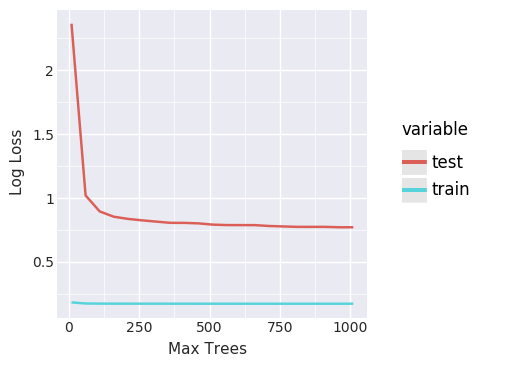

In [907]:
# Takes a while. Only run if needed, and use as many processes as needed as there is no progress display.

def iteration(i):
    try:
        clf = RandomForestClassifier(n_estimators=i, max_depth=None, 
                                     random_state=8, max_features='auto')
        loss = TrainTest([], [])        
        run_classifier_CV(clf, train[:3], test[:3], target_names, loss)
        return (i, sum(loss.train) / 3, sum(loss.test) / 3)
    except:
        import traceback
        traceback.print_exc()

range_ = range(10, 1050, 50)
p = Pool(processes=8)
result = p.map(iteration, range_)
p.close()
p.join()

plot_hypervariable(result, 'Max Trees')

Now let's get an approximate value for the best depth of the tree. For speed we'll set it at 100 trees and leave everything else ads default.

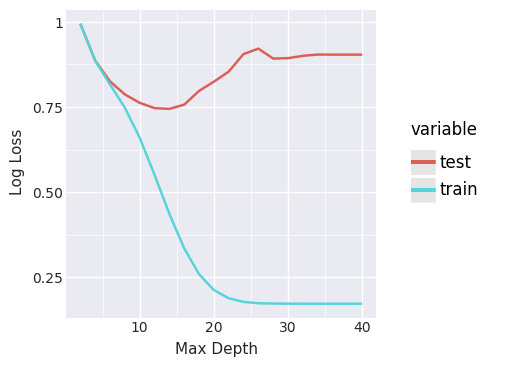

In [716]:
# Takes a while. Only run if needed, and use as many processes as needed as there is no progress display.

def iteration(i):
    try:
        clf = RandomForestClassifier(n_estimators=100, max_depth=i, 
                                     random_state=8, max_features='auto')
        loss = TrainTest([], [])
        run_classifier_CV(clf, train[:3], test[:3], target_names, loss)
        return (i, sum(loss.train) / 3, sum(loss.test) / 3)
    except:
        import traceback
        traceback.print_exc()

range_ = range(2, 42, 2)
p = Pool(processes=8)
result = p.map(iteration, range_)
p.close()
p.join()

plot_hypervariable(result, 'Max Depth')

Now, with the above information, let's try to tune for other hyperparameters like bootstraping, criterion, max_features, and the minimum number of samples per split. It turns out some of these don't seem to change as we search this hyperparameter space using grid search.

In [961]:
X = data.loc[:, 1:]
t = data.OutcomeType

param = [{'n_estimators': [100, 250],          # to see if no. trees optimize other parmas differently
          'max_depth': [11, 12, 13],
#           'criterion': ['gini', 'entropy'],  # entropy < gini -- In all cases I've seen, so remove
#           'max_features': ['sqrt', 'log2'],  # log2 ~= sqrt -- ditto (ugh log2 and sqrt of 10 = floor 3)
          'bootstrap': [False],                # True < False -- ditto
          'min_samples_split': [2, 3, 4]}]

rf_clf = RandomForestClassifier(random_state=8)

clf = GridSearchCV(rf_clf, param, scoring=ln_loss_scorer, n_jobs=-1,
                   cv=skf_generator(data, n_splits), verbose=1)

clf.fit(X, t)

print_grid_cv_results(clf, X, t)

Fitting 8 folds for each of 18 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  2.5min finished


,score,95% CI,min_samples_split,n_estimators,bootstrap,max_depth
15,-0.742,+/-0.025,3,250,False,13
17,-0.743,+/-0.025,4,250,False,13
13,-0.744,+/-0.023,2,250,False,13
14,-0.746,+/-0.028,3,100,False,13
7,-0.747,+/-0.023,2,250,False,12
9,-0.748,+/-0.023,3,250,False,12
11,-0.748,+/-0.023,4,250,False,12
12,-0.748,+/-0.024,2,100,False,13
16,-0.748,+/-0.026,4,100,False,13
6,-0.749,+/-0.023,2,100,False,12


Ideally, for random forest we shouldn't high correlations between our features, otherwise when considers randomly one over the other at a split we might increase our variance quite a bit. Correlations seem to be fairly low despite most being positive.

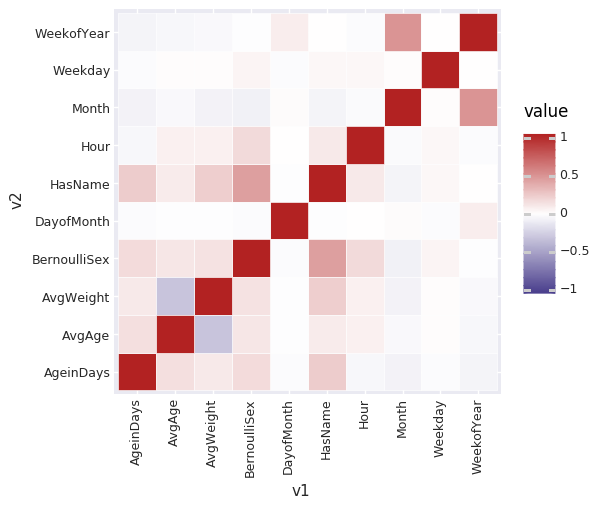

In [962]:
df_corr = df.corr()
df_corr = df_corr.stack().reset_index()
df_corr.columns = ['v1','v2','value']

(ggplot(df_corr, aes(x='v1', y='v2', fill='value'))
 + geom_tile(color='white', size=0.25)
 + scale_fill_gradientn(colors=('darkslateblue', 'white', 'firebrick'), limits=(-1,1))
 + theme_seaborn()
 + theme(axis_text_x = element_text(angle = 90, size=9),
         axis_text_y = element_text(size=9))
 + coord_equal()
).draw().set_size_inches(5,5)

Using the information above from the hyperparameter tuning, let's increase the number of trees to 1000 and print out more detailed information about the performance of this classifer. Also I'd expect that we'd liekly see an improvement to the mean score and variance with a higher number of trees. So it should be worth the extra training time.


Fold 1 of 8
Train log loss: 0.469090909782
Test log loss: 0.739027042348
                 precision    recall  f1-score   support

       Adoption       0.72      0.82      0.77      1194
           Died       1.00      0.05      0.09        22
     Euthanasia       0.74      0.25      0.37       173
Return_to_owner       0.52      0.54      0.53       535
       Transfer       0.78      0.74      0.76      1048

    avg / total       0.71      0.70      0.70      2972

Classifier score (accuracy): 0.704576043069


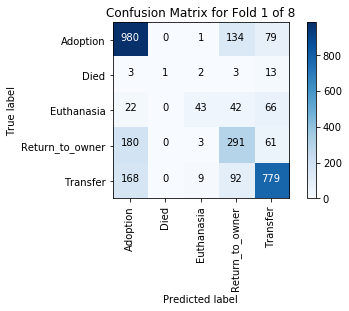

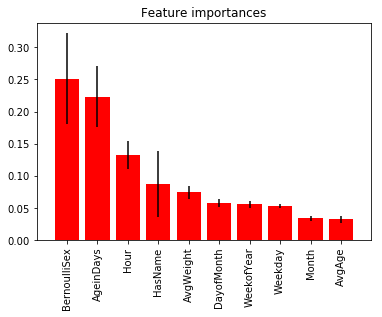


Fold 2 of 8
Train log loss: 0.470595265867
Test log loss: 0.733867427452
                 precision    recall  f1-score   support

       Adoption       0.72      0.85      0.78      1194
           Died       1.00      0.09      0.17        22
     Euthanasia       0.71      0.24      0.36       172
Return_to_owner       0.50      0.48      0.49       535
       Transfer       0.78      0.74      0.76      1048

    avg / total       0.70      0.70      0.69      2971

Classifier score (accuracy): 0.701447324133


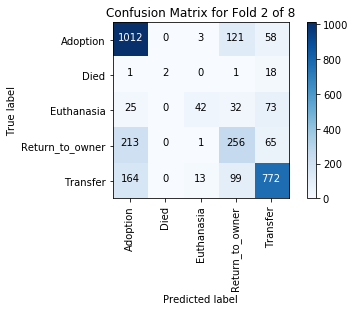

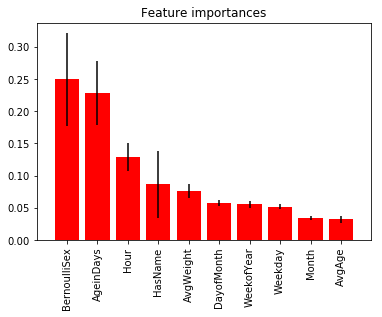


Fold 3 of 8
Train log loss: 0.47104997062
Test log loss: 0.728531397379
                 precision    recall  f1-score   support

       Adoption       0.72      0.83      0.77      1194
           Died       0.80      0.18      0.30        22
     Euthanasia       0.60      0.16      0.26       172
Return_to_owner       0.52      0.53      0.53       535
       Transfer       0.77      0.74      0.76      1047

    avg / total       0.70      0.70      0.69      2970

Classifier score (accuracy): 0.70101010101


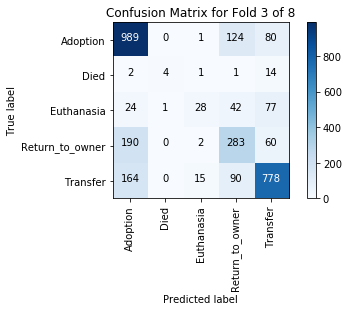

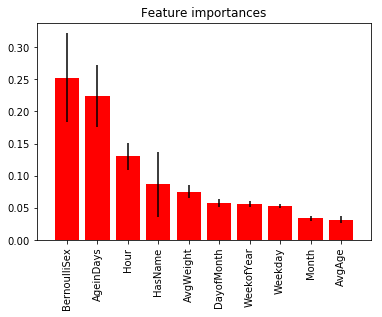


Fold 4 of 8
Train log loss: 0.468421597954
Test log loss: 0.728506350643
                 precision    recall  f1-score   support

       Adoption       0.71      0.83      0.77      1194
           Died       1.00      0.05      0.09        22
     Euthanasia       0.62      0.19      0.29       172
Return_to_owner       0.52      0.48      0.50       535
       Transfer       0.77      0.75      0.76      1047

    avg / total       0.69      0.70      0.68      2970

Classifier score (accuracy): 0.69696969697


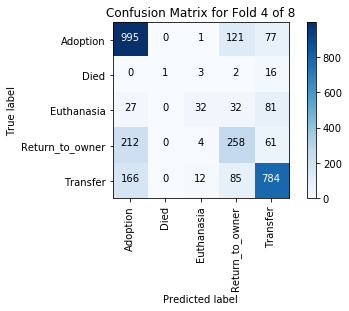

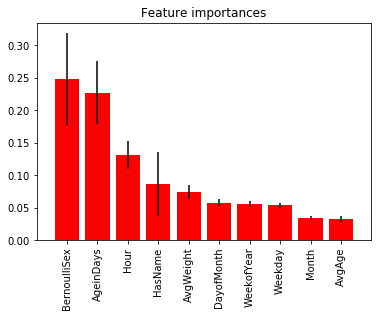


Fold 5 of 8
Train log loss: 0.469538115642
Test log loss: 0.770471143688
                 precision    recall  f1-score   support

       Adoption       0.71      0.81      0.76      1194
           Died       0.50      0.09      0.15        22
     Euthanasia       0.67      0.19      0.29       172
Return_to_owner       0.46      0.48      0.47       535
       Transfer       0.78      0.73      0.75      1047

    avg / total       0.68      0.68      0.67      2970

Classifier score (accuracy): 0.683164983165


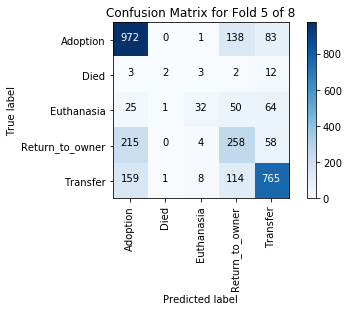

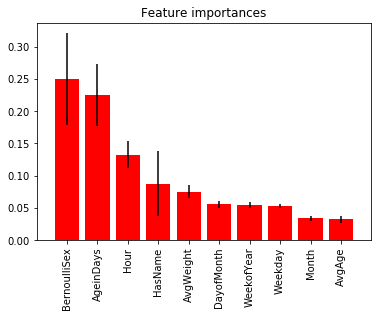


Fold 6 of 8
Train log loss: 0.467207518471
Test log loss: 0.744939225422
                 precision    recall  f1-score   support

       Adoption       0.71      0.82      0.76      1194
           Died       1.00      0.05      0.09        22
     Euthanasia       0.63      0.21      0.31       172
Return_to_owner       0.52      0.50      0.51       535
       Transfer       0.76      0.74      0.75      1047

    avg / total       0.69      0.69      0.68      2970

Classifier score (accuracy): 0.691245791246


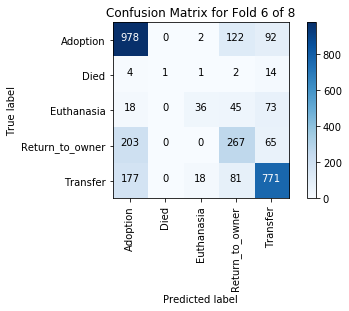

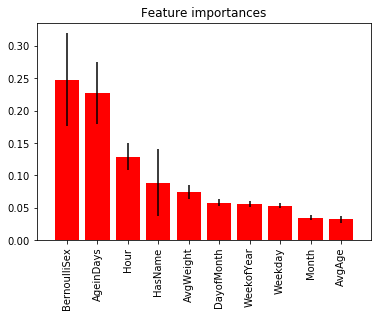


Fold 7 of 8
Train log loss: 0.472546500714
Test log loss: 0.744177289782
                 precision    recall  f1-score   support

       Adoption       0.71      0.84      0.77      1193
           Died       1.00      0.05      0.09        21
     Euthanasia       0.75      0.19      0.31       172
Return_to_owner       0.49      0.49      0.49       535
       Transfer       0.78      0.72      0.75      1047

    avg / total       0.70      0.69      0.68      2968

Classifier score (accuracy): 0.692722371968


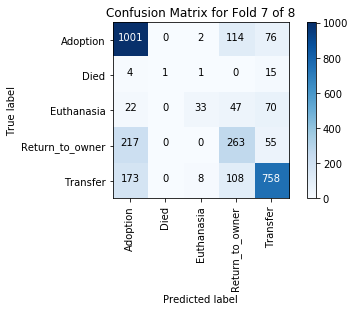

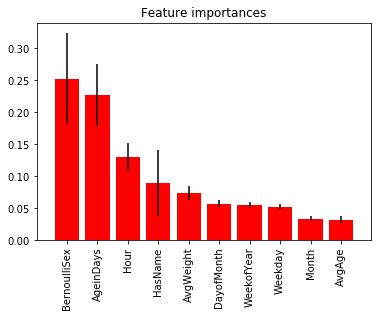


Fold 8 of 8
Train log loss: 0.470118147643
Test log loss: 0.741649871291
                 precision    recall  f1-score   support

       Adoption       0.72      0.82      0.77      1193
           Died       0.60      0.14      0.23        21
     Euthanasia       0.76      0.22      0.34       172
Return_to_owner       0.50      0.51      0.51       535
       Transfer       0.77      0.74      0.76      1047

    avg / total       0.70      0.70      0.69      2968

Classifier score (accuracy): 0.697102425876


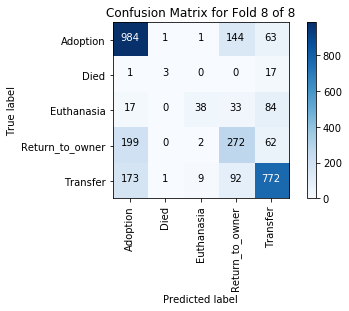

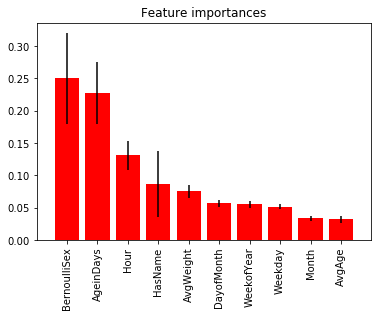

Avg. train log loss: 0.469821003337 +/- 0.00302280156945
Avg. test log loss: 0.741396218501 +/- 0.0245943967336


In [981]:
rf_clf = RandomForestClassifier(n_estimators=1000, max_depth=13, bootstrap=False, 
                                min_samples_split=3, random_state=8, max_features='auto', 
                                n_jobs=-1)

loss = TrainTest([], [])

clfs = run_classifier_CV(rf_clf, train, test, target_names, loss, plot=True)

print('Avg. train log loss: {} +/- {}'.format(np.mean(loss.train), np.std(loss.train) * 1.96))
print('Avg. test log loss: {} +/- {}'.format(np.mean(loss.test), np.std(loss.test)* 1.96))

If we peak at the hold_out data we can use it to see if we get an improvement in the scores when soft voting via bagging on the k folds used for training compared to simply training with all available data. As this is the only purpose of this peak it should be okay. This will help us see if there is potential value in using bagging in this case or if it's just better to train with all our data. If the difference is small it might be better to avoid bagging if we decide to use an esemble method (like combining RF with other classifiers) for simplicity.

WITH Soft Voting on Folds:

Test log loss: 0.772650073515
                 precision    recall  f1-score   support

       Adoption       0.72      0.82      0.77      1219
           Died       0.67      0.09      0.15        23
     Euthanasia       0.59      0.17      0.26       178
Return_to_owner       0.48      0.51      0.49       506
       Transfer       0.76      0.71      0.73      1044

    avg / total       0.68      0.69      0.67      2970

WITHOUT Soft Voting on Folds:

Test log loss: 0.77357002065
                 precision    recall  f1-score   support

       Adoption       0.72      0.82      0.77      1219
           Died       0.67      0.09      0.15        23
     Euthanasia       0.59      0.17      0.26       178
Return_to_owner       0.48      0.51      0.49       506
       Transfer       0.76      0.71      0.74      1044

    avg / total       0.68      0.69      0.68      2970



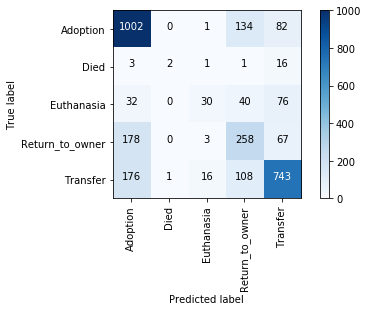

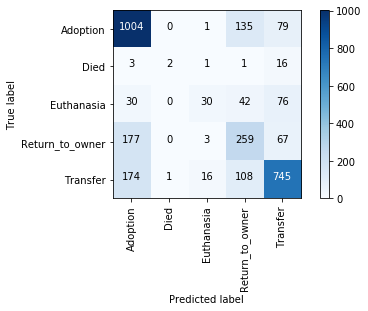

In [982]:
print("WITH Soft Voting on Folds:")

X = TrainTest(data.iloc[:, 1:], hold_out.iloc[:, 1:])
t = TrainTest(data.OutcomeType, hold_out.OutcomeType)
pred_proba = average([clfs[i].predict_proba(X.test) for i in range(n_splits)], axis=0)
pred = TrainTest(None, [target_names[argmax(pred_proba[i])] for i in range(len(X.test))])
loss = TrainTest(None, [calc_ln_loss(t.test, pred_proba, target_names)])
plot_results(X, t, target_names, loss, pred, 1, show_title=False)

print("WITHOUT Soft Voting on Folds:")
rf_clf.fit(X.train, t.train)
pred_proba = TrainTest(None, rf_clf.predict_proba(X.test))
pred = TrainTest(None, [target_names[argmax(pred_proba.test[i])] for i in range(len(X.test))])
loss = TrainTest(None, [calc_ln_loss(t.test, pred_proba.test, target_names)])
plot_results(X, t, target_names, loss, pred, 1, show_title=False)


In [983]:
X = data.loc[:, columns]
t = data.OutcomeType

param = [{'n_estimators': [50, 100, 300],
          'max_depth': [5, 6],
          'learning_rate': [0.1, 0.05]}]

gb_clf = GradientBoostingClassifier(random_state=8)

clf = GridSearchCV(gb_clf, param, scoring=ln_loss_scorer, n_jobs=-1,
                   cv=skf_generator(data, n_splits), verbose=1)

clf.fit(X, t)

print_grid_cv_results(clf, X, t)

Fitting 8 folds for each of 12 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  9.5min finished


,score,95% CI,n_estimators,learning_rate,max_depth
4,-0.756,+/- 0.030,100,0.10,6
8,-0.756,+/- 0.031,300,0.05,5
1,-0.758,+/- 0.027,100,0.10,5
10,-0.758,+/- 0.028,100,0.05,6
3,-0.759,+/- 0.028,50,0.10,6
11,-0.760,+/- 0.031,300,0.05,6
0,-0.766,+/- 0.026,50,0.10,5
7,-0.766,+/- 0.028,100,0.05,5
2,-0.770,+/- 0.033,300,0.10,5
9,-0.785,+/- 0.025,50,0.05,6


In [1024]:
X = data.loc[:, columns]
t = data.OutcomeType

param = [{'n_estimators': [50, 75],
          'max_depth': [6, 7, 8, 9],
          'subsample': [1, 0.875, 0.75]}]

gb_clf = GradientBoostingClassifier(random_state=8)

clf = GridSearchCV(gb_clf, param, scoring=ln_loss_scorer, n_jobs=-1,
                   cv=skf_generator(data, n_splits), verbose=1)

clf.fit(X, t)

print_grid_cv_results(clf, X, t)

Fitting 8 folds for each of 24 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 17.0min finished


,score,95% CI,n_estimators,subsample,max_depth
7,-0.749,+/- 0.028,50,0.875,7
10,-0.750,+/- 0.028,75,0.875,7
8,-0.751,+/- 0.026,50,0.750,7
14,-0.751,+/- 0.027,50,0.750,8
11,-0.751,+/- 0.028,75,0.750,7
13,-0.751,+/- 0.028,50,0.875,8
5,-0.752,+/- 0.025,75,0.750,6
4,-0.752,+/- 0.030,75,0.875,6
6,-0.753,+/- 0.028,50,1.000,7
9,-0.754,+/- 0.030,75,1.000,7



Fold 1 of 8
Train log loss: 0.550706810351
Test log loss: 0.744377610087
                 precision    recall  f1-score   support

       Adoption       0.72      0.82      0.77      1194
           Died       0.50      0.14      0.21        22
     Euthanasia       0.60      0.27      0.37       173
Return_to_owner       0.53      0.50      0.51       535
       Transfer       0.77      0.74      0.76      1048

    avg / total       0.69      0.70      0.69      2972

Classifier score (accuracy): 0.699528936743

Fold 2 of 8
Train log loss: 0.549567925593
Test log loss: 0.738698396004
                 precision    recall  f1-score   support

       Adoption       0.72      0.83      0.77      1194
           Died       0.50      0.09      0.15        22
     Euthanasia       0.66      0.29      0.40       172
Return_to_owner       0.51      0.49      0.50       535
       Transfer       0.78      0.73      0.75      1048

    avg / total       0.70      0.70      0.69      2971

Clas

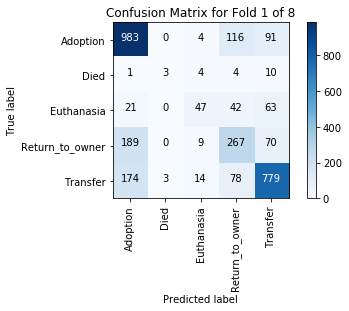

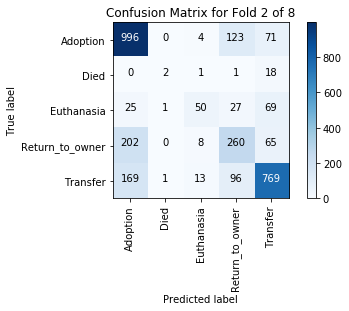

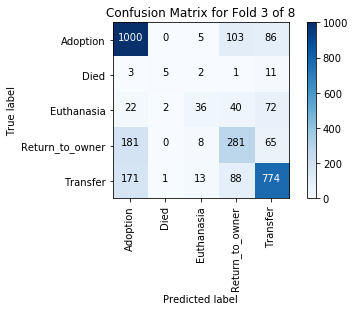

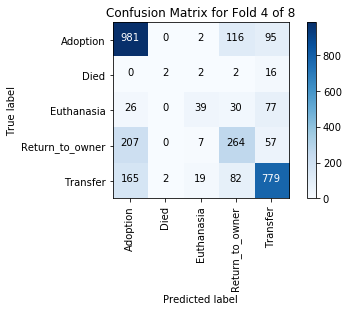

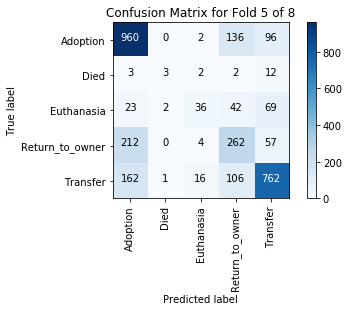

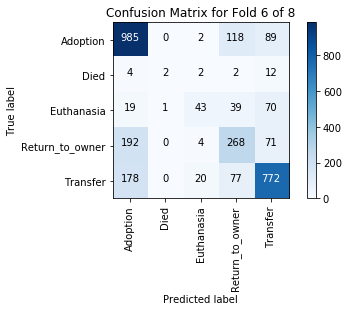

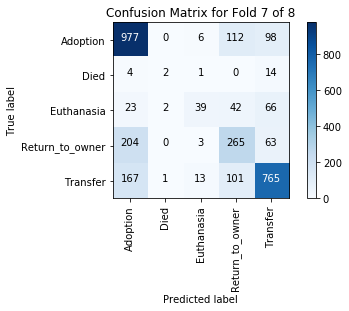

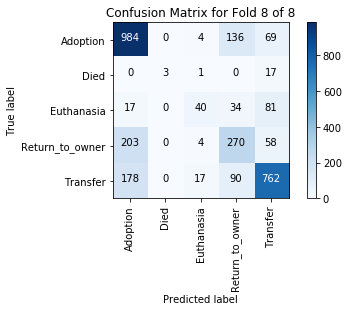

In [1028]:
gb_clf = GradientBoostingClassifier(n_estimators=50, max_depth=7, subsample=0.875, random_state=8)

loss = TrainTest([], [])
clfs = run_classifier_CV(gb_clf, train, test, target_names, loss, plot=True)

print('Avg. train log loss: {} +/- {}'.format(np.mean(loss.train), np.std(loss.train) * 1.96))
print('Avg. test log loss: {} +/- {}'.format(np.mean(loss.test), np.std(loss.test)* 1.96))

GB and RF log loss are similar (although with the current tuning RF is better). However, GB seems to do better on Died and Euthanized, so maybe an ensemble of the two will be helpufl?

In [1030]:
voting_clf = VotingClassifier([('rf', rf_clf), ('gb', gb_clf)], voting='soft')

# score using cross validation
clf_list = [rf_clf, gb_clf, voting_clf]
name_list = ['Random Forest', 'Gradient Boosting', 'Ensemble']

for clf, name in zip(clf_list,name_list) :
    scores = cross_val_score(clf, X, t, scoring=ln_loss_scorer, cv=skf_generator(data, n_splits))
    print("Log Loss: %0.3f +/- %0.3f (%s 95%% CI)" % (scores.mean(), scores.std()*1.96, name))

Log Loss: -0.741 +/- 0.025 (Random Forest 95% CI)
Log Loss: -0.749 +/- 0.028 (Gradient Boosting 95% CI)
Log Loss: -0.735 +/- 0.027 (Ensemble 95% CI)
